In [118]:
import os
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from matplotlib import rcParams
from sklearn.base import BaseEstimator
from sklearn.datasets import load_digits

from keras.layers import Dense, Flatten, Conv2D, Input, Lambda
from keras.layers import BatchNormalization
from keras import Model
from keras.optimizers import Adam
import keras.backend as K
import tensorflow_probability as tfp

sns.set(context='poster', style='whitegrid')
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
# %load_ext autoreload
# %autoreload 2

# Incorporating TFP into basic NN models

Let's on a toy problem - given some one-dimensional inputs $x$, we want to predict some function $y(x)$. This twist we add here however is that we'll make $y(x)$ noisy and try to quantity our uncertaintity about our predictions by asking a neural network to output a probability disribution rather than just using point estimates.

Below, we make some synthetic data.

x shape: (10000,)
y shape: (10000,)


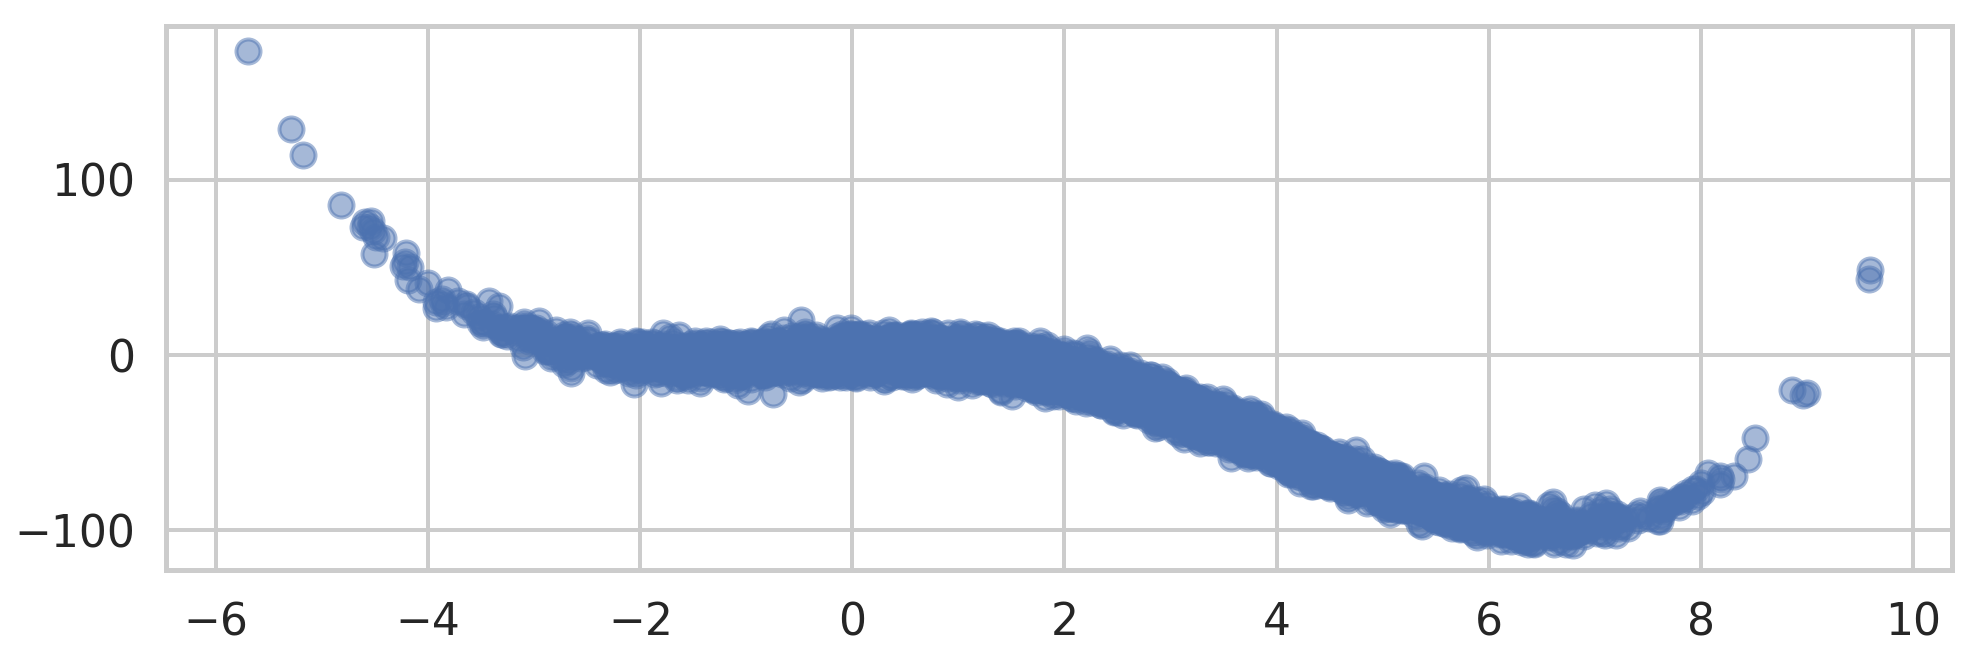

In [140]:
NUM_SAMPLES = 10000
x = np.random.normal(loc=2, scale=2, size=NUM_SAMPLES)
y = 0.1 * x**4 - 0.7 * x**3 - 2 * x**2 \
    + np.random.randn(NUM_SAMPLES) * 5 + np.sin(x)
print('x shape:', x.shape)
print('y shape:', y.shape)

plt.figure(figsize=(16, 5))
plt.scatter(x, y, alpha=0.5)

In [125]:
def make_model(dense_nodes, activation='relu', batch_norm=True):
    
    # An abuse of Keras to make things work since there is a shape mismatch
    # between what we want the model to output and the true labels
    input_ = Input(shape=(1,), dtype='float32')
    output_ = Input(shape=(1,), dtype='float32')
    
    # Vanilla dense topology
    for index, num_nodes in enumerate(dense_nodes):
        if index == 0:
            a = Dense(num_nodes, activation=activation)(input_)
        else:
            a = Dense(num_nodes, activation=activation)(a)
        if batch_norm:
            a = BatchNormalization()(a)
            
    # Output parameters of probability distribution
    mean = Dense(1, activation='linear')(a)
    std = Dense(1, activation='relu')(a) # Stddev must be non-negative
    model = Model(inputs=[input_, output_], outputs=[mean, std])
    
    # Define custom loss function
    normal = tfp.distributions.Normal(mean, std + 1e-5) # Numerical stability
    log_probs = normal.log_prob(output_)
    loss = -tf.keras.backend.mean(log_probs)
    model.add_loss(loss)
    return model

In [126]:
model = make_model(
    dense_nodes=[32, 16],
    activation='elu',
    batch_norm=True)

In [131]:
model.compile(optimizer=Adam(lr=0.0001))
model.fit(
    [x, y], y=None, validation_split=0.1, epochs=100,
    batch_size=128, shuffle=False)

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 5s 578us/step - loss: 3.1556 - val_loss: 3.0941
Epoch 2/100
9000/9000 [==============================] - 0s 41us/step - loss: 3.1553 - val_loss: 3.0943
Epoch 3/100
9000/9000 [==============================] - 0s 49us/step - loss: 3.1553 - val_loss: 3.0944
Epoch 4/100
9000/9000 [==============================] - 0s 49us/step - loss: 3.1552 - val_loss: 3.0946
Epoch 5/100
9000/9000 [==============================] - 0s 50us/step - loss: 3.1552 - val_loss: 3.0948
Epoch 6/100
9000/9000 [==============================] - 0s 53us/step - loss: 3.1552 - val_loss: 3.0945
Epoch 7/100
9000/9000 [==============================] - 0s 50us/step - loss: 3.1552 - val_loss: 3.0948
Epoch 8/100
9000/9000 [==============================] - 0s 50us/step - loss: 3.1552 - val_loss: 3.0947
Epoch 9/100
9000/9000 [==============================] - 0s 53us/step - loss: 3.1552 - val_loss: 3.0961
Epoch 10/100
90

In [151]:
def plot_predictions(model, x, y, ylim=None):
    indices = x.argsort()
    y_pred, std_pred = model.predict([x, y])
    plt.figure(figsize=(16, 10))
    ax = plt.gca()
    ax.scatter(x, y, s=0.5, label='True data')
    ax.scatter(x, y_pred, s=0.5, label='Predicted mean')
    if ylim is not None and len(ylim) == 2:
        ax.set_ylim(ylim)
    ax.set_xlabel('Input')
    ax.set_ylabel('Target')
    ax.fill_between(
        x[indices],
        y_pred[indices].squeeze() - 3 * std_pred[indices].squeeze(),
        y_pred[indices].squeeze() + 3 * std_pred[indices].squeeze(),
        alpha=0.2,
        color='orange', label='+/- 3 stddevs')
    ax.legend()
    return ax

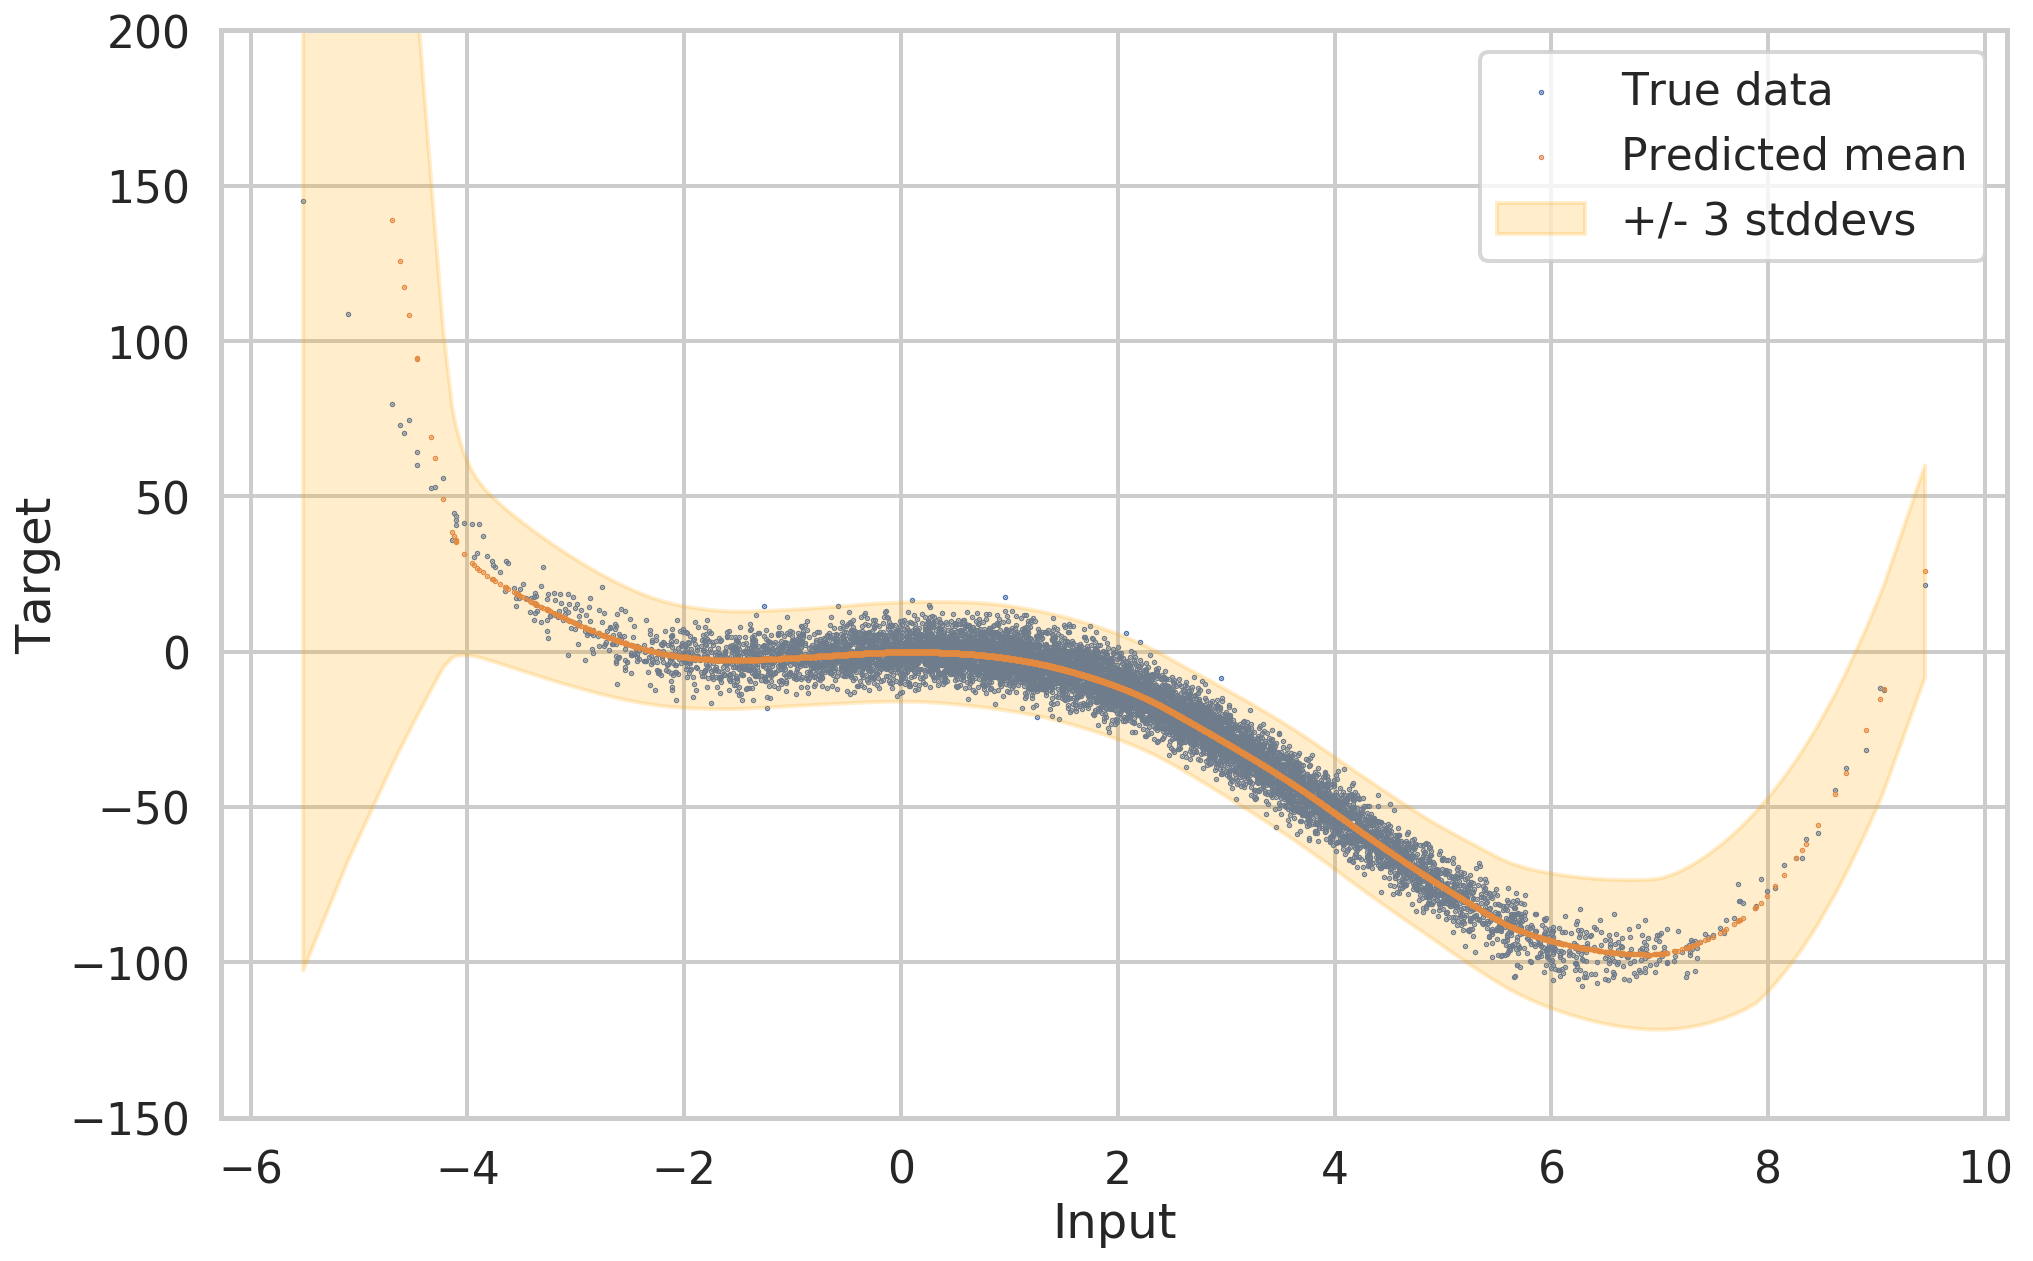

In [136]:
plot_predictions(model, x, y, (-150, 200))

# Try a new function

x shape: (10000,)
y shape: (10000,)


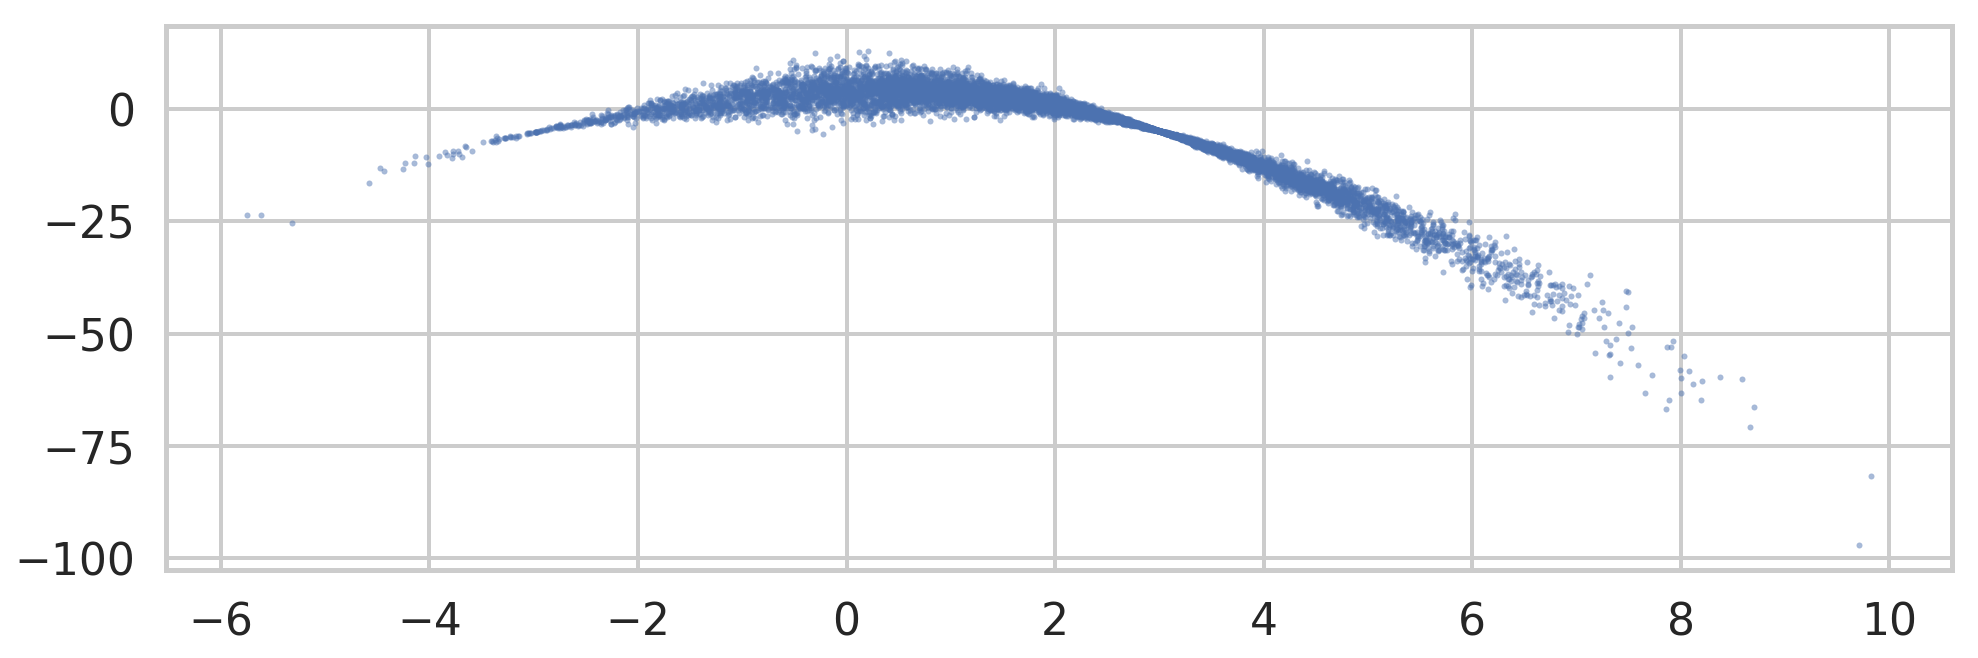

In [143]:
NUM_SAMPLES = 10000
x = np.random.normal(loc=2, scale=2, size=NUM_SAMPLES)
y = -x ** 2 + 4 \
    + np.random.randn(NUM_SAMPLES) * (3 - np.abs(x)) + np.sin(x)
print('x shape:', x.shape)
print('y shape:', y.shape)

plt.figure(figsize=(16, 5))
plt.scatter(x, y, s=1, alpha=0.5)

In [144]:
model = make_model([32, 16, 8], 'elu', True)

In [153]:
model.compile(optimizer=Adam(lr=0.00001))
model.fit(
    [x, y], y=None, validation_split=0.1, epochs=25,
    batch_size=128, shuffle=False)

Train on 9000 samples, validate on 1000 samples
Epoch 1/25
9000/9000 [==============================] - 6s 719us/step - loss: 1.9449 - val_loss: 1.7055
Epoch 2/25
9000/9000 [==============================] - 1s 58us/step - loss: 1.9448 - val_loss: 1.7054
Epoch 3/25
9000/9000 [==============================] - 1s 59us/step - loss: 1.9448 - val_loss: 1.7053
Epoch 4/25
9000/9000 [==============================] - 1s 61us/step - loss: 1.9448 - val_loss: 1.7051
Epoch 5/25
9000/9000 [==============================] - 1s 62us/step - loss: 1.9448 - val_loss: 1.7052
Epoch 6/25
9000/9000 [==============================] - 1s 58us/step - loss: 1.9448 - val_loss: 1.7052
Epoch 7/25
9000/9000 [==============================] - 1s 60us/step - loss: 1.9448 - val_loss: 1.7052
Epoch 8/25
9000/9000 [==============================] - 1s 61us/step - loss: 1.9447 - val_loss: 1.7053
Epoch 9/25
9000/9000 [==============================] - 0s 48us/step - loss: 1.9447 - val_loss: 1.7053
Epoch 10/25
9000/9000 [=

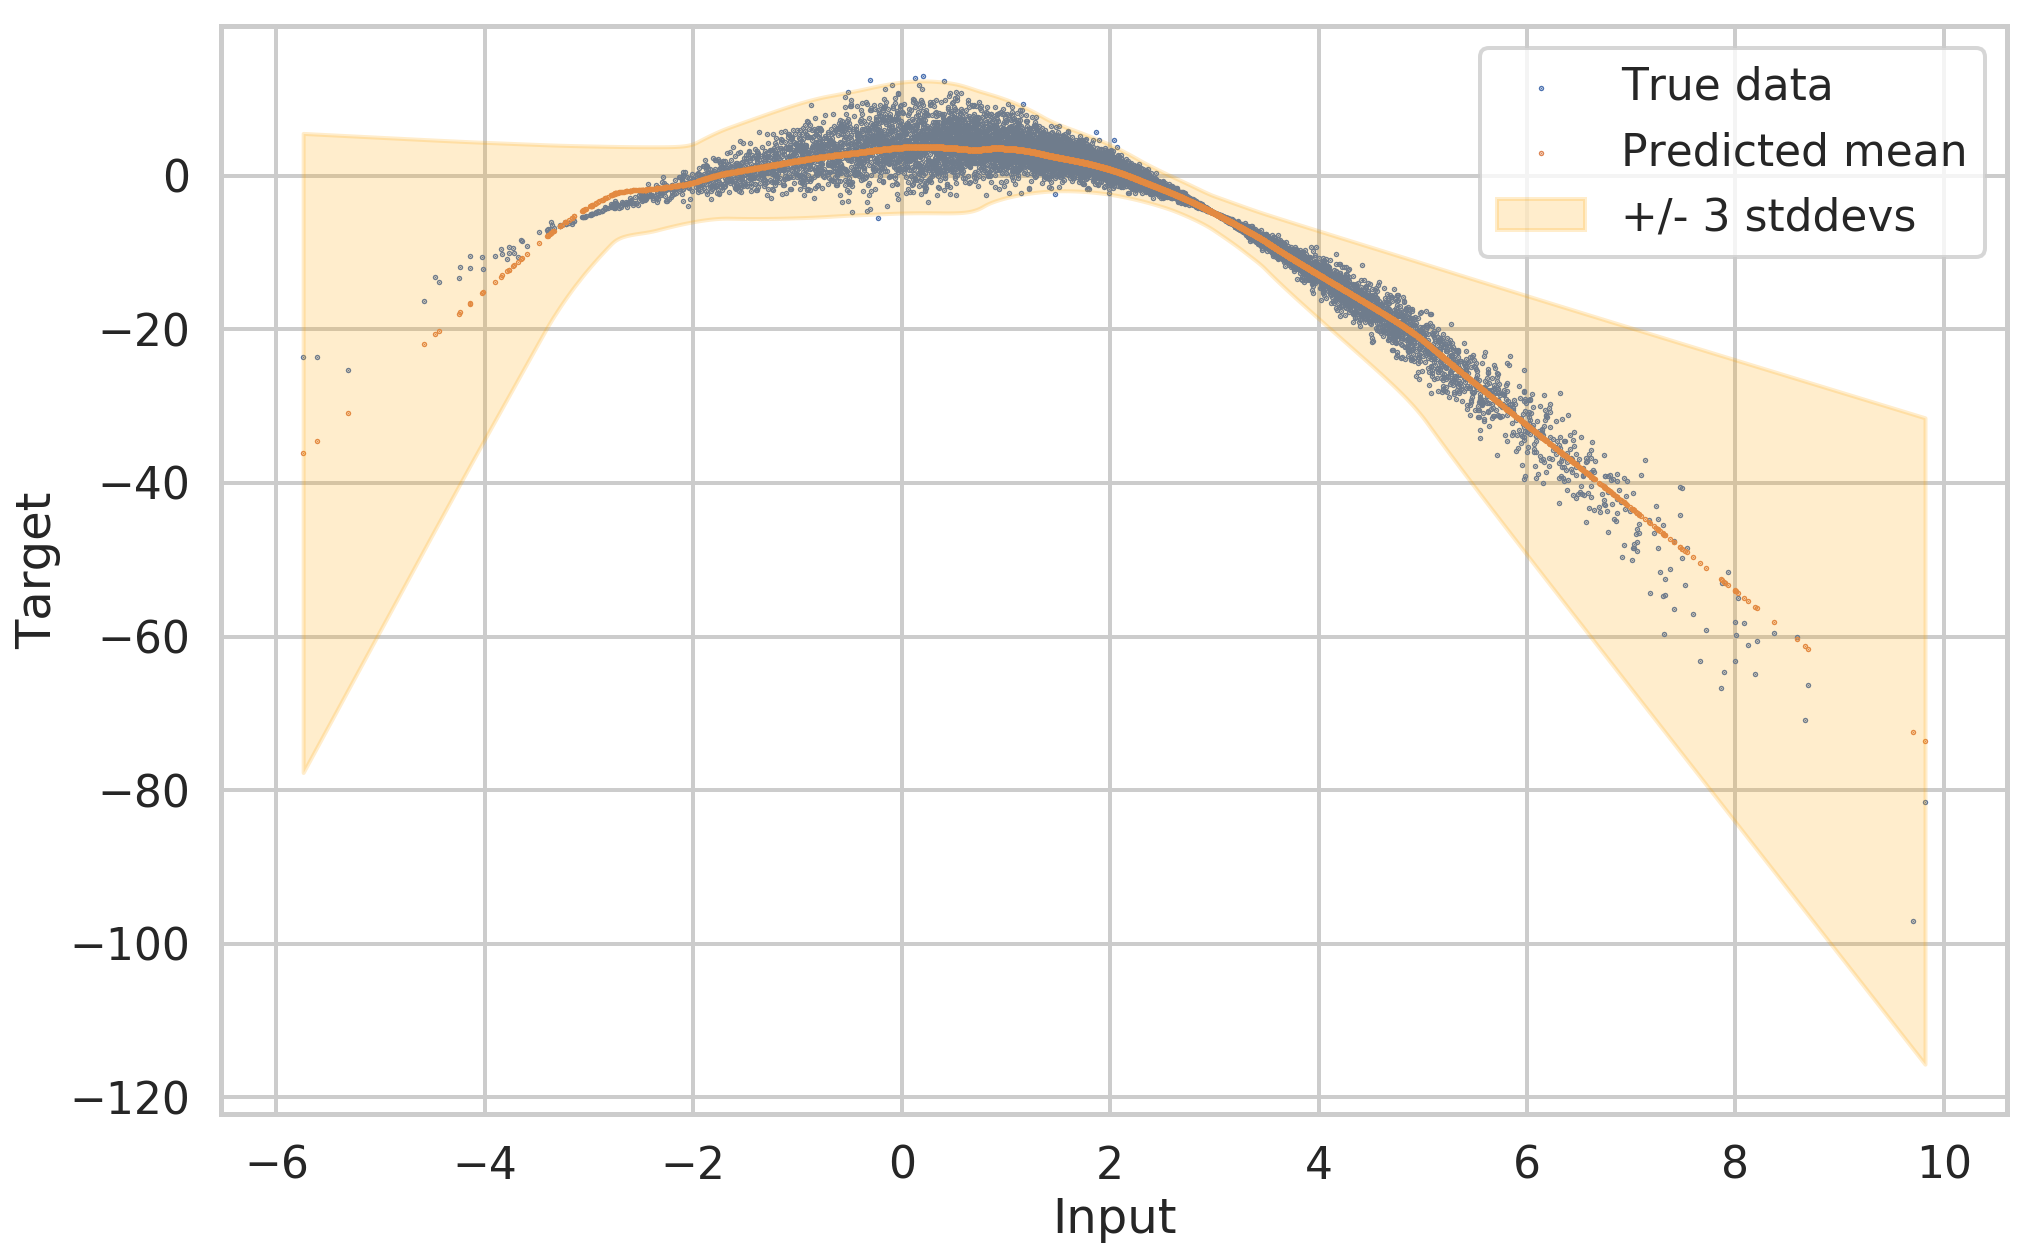

In [154]:
plot_predictions(model, x, y)